In [26]:
# Importing the necessary modules
import torch # For creating tensors and neural network
import torch.nn as nn # For creating layers and activation functions
import torch.optim as optim # For creating optimizer
import numpy as np # For creating arrays and sampling data
import matplotlib.pyplot as plt # For plotting results

# Setting the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining the constants for the neural network
#NUM_EPOCHS = 400 # Number of epochs for training
NUM_EPOCHS = 30 # Number of epochs for training
NUM_INPUTS = 3 # Number of inputs: D, S_x, tau
NUM_OUTPUTS = 1 # Number of outputs: p
NUM_HIDDEN1 = 600 # Number of neurons in the first hidden layer
NUM_HIDDEN2 = 200 # Number of neurons in the second hidden layer
BATCH_SIZE = 32 # Size of mini-batches for gradient descent
INIT_LR = 6e-4 # Initial learning rate for training
LR_FACTOR = 0.5 # Factor to multiply learning rate when adapting
LR_PATIENCE = 5 # Number of epochs to wait before adapting learning rate
LR_THRESHOLD = 0.0005 # Threshold to check improvement in loss before adapting learning rate
LR_COOLDOWN = 10 # Number of epochs to wait after adapting learning rate

# Defining the constants for the data generation
TRAIN_SIZE = 80000 # Number of samples in the training dataset
TEST_SIZE = 10000 # Number of samples in the test dataset
RHO_MIN = 0.0 # Minimum value of rho (density) for sampling
RHO_MAX = 10.1 # Maximum value of rho (density) for sampling
EPS_MIN = 0.0 # Minimum value of eps (specific internal energy) for sampling
EPS_MAX = 2.02 # Maximum value of eps (specific internal energy) for sampling
VX_MIN = 0.0 # Minimum value of v_x (velocity in x direction) for sampling
VX_MAX = 0.721 # Maximum value of v_x (velocity in x direction) for sampling


In [27]:

# Defining a function to generate data from primitive variables to conservative variables
def generate_data(size):
    """
    Generates data from primitive variables to conservative variables.

    Parameters:
        size (int): The number of samples to generate.

    Returns:
        X (torch.Tensor): The tensor of shape (size, NUM_INPUTS) containing the conservative variables D, S_x, tau.
        y (torch.Tensor): The tensor of shape (size, NUM_OUTPUTS) containing the primitive variable p.
    """
    # Sampling primitive variables from uniform distributions over given intervals
    rho = np.random.uniform(RHO_MIN, RHO_MAX, size) # Density
    eps = np.random.uniform(EPS_MIN, EPS_MAX, size) # Specific internal energy
    vx = np.random.uniform(VX_MIN, VX_MAX, size) # Velocity in x direction

    # Calculating primitive variable p (pressure) from equation of state (EOS)
    gamma = 4/3 # Adiabatic index for ultra-relativistic gas EOS
    p = rho * eps * (gamma - 1) # Pressure

    # Calculating conservative variables from primitive variables using equations (2) from Dieseldorst et al.
    W = 1 / np.sqrt(1 - vx**2) # Lorentz factor
    h = 1 + eps + p / rho # Specific enthalpy
    D = rho * W # Conserved density
    Sx = rho * h * W**2 * vx # Conserved momentum in x direction
    tau = rho * h * W**2 - p - D # Conserved energy density

    # Converting numpy arrays to torch tensors and moving them to device
    X = torch.tensor(np.stack([D, Sx, tau], axis=1), dtype=torch.float32).to(device) # Conservative variables
    y = torch.tensor(p, dtype=torch.float32).unsqueeze(1).to(device) # Primitive variable p

    # Returning X and y
    return X, y


In [28]:

# Generating training and test datasets using the generate_data function
X_train, y_train = generate_data(TRAIN_SIZE)
X_test, y_test = generate_data(TEST_SIZE)


In [29]:

# Defining a class for the neural network model
class NeuralNetwork(nn.Module):
    """
    A class for the neural network model that performs conservative-to-primitive inversion.

    Attributes:
        fc1 (nn.Linear): The first fully connected layer with NUM_INPUTS inputs and NUM_HIDDEN1 outputs.
        fc2 (nn.Linear): The second fully connected layer with NUM_HIDDEN1 inputs and NUM_HIDDEN2 outputs.
        fc3 (nn.Linear): The third fully connected layer with NUM_HIDDEN2 inputs and NUM_OUTPUTS outputs.
        sigmoid (nn.Sigmoid): The sigmoid activation function for the hidden layers.
        relu (nn.ReLU): The ReLU activation function for the output layer.

    Methods:
        forward(x): Performs the forward pass of the neural network on the input x and returns the output y.
    """
    def __init__(self):
        """
        Initializes the neural network model with the attributes defined above.
        """
        super(NeuralNetwork, self).__init__() # Calling the superclass constructor
        self.fc1 = nn.Linear(NUM_INPUTS, NUM_HIDDEN1) # First fully connected layer
        self.fc2 = nn.Linear(NUM_HIDDEN1, NUM_HIDDEN2) # Second fully connected layer
        self.fc3 = nn.Linear(NUM_HIDDEN2, NUM_OUTPUTS) # Third fully connected layer
        self.sigmoid = nn.Sigmoid() # Sigmoid activation function
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, x):
        """
        Performs the forward pass of the neural network on the input x and returns the output y.

        Parameters:
            x (torch.Tensor): The input tensor of shape (batch_size, NUM_INPUTS) containing the conservative variables.

        Returns:
            y (torch.Tensor): The output tensor of shape (batch_size, NUM_OUTPUTS) containing the primitive variable p.
        """
        x = self.fc1(x) # Passing x through the first fully connected layer
        x = self.sigmoid(x) # Applying sigmoid activation function
        x = self.fc2(x) # Passing x through the second fully connected layer
        x = self.sigmoid(x) # Applying sigmoid activation function
        y = self.fc3(x) # Passing x through the third fully connected layer
        y = self.relu(y) # Applying ReLU activation function
        return y


In [30]:

# Creating an instance of the neural network model and moving it to device
model = NeuralNetwork().to(device)

# Defining the loss function as mean squared error
criterion = nn.MSELoss()

# Defining the optimizer as Adam with initial learning rate
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)


In [31]:

# Defining a function to calculate other primitive variables from p using equations (A2), (A3), (A4), (A5) from Dieseldorst et al.
def calculate_primitives(X, p):
    """
    Calculates other primitive variables from p using equations (A2), (A3), (A4), (A5) from Dieseldorst et al.

    Parameters:
        X (torch.Tensor): The tensor of shape (batch_size, NUM_INPUTS) containing the conservative variables D, S_x, tau.
        p (torch.Tensor): The tensor of shape (batch_size, NUM_OUTPUTS) containing the primitive variable p.

    Returns:
        rho (torch.Tensor): The tensor of shape (batch_size, 1) containing the primitive variable rho (density).
        eps (torch.Tensor): The tensor of shape (batch_size, 1) containing the primitive variable eps (specific internal energy).
        vx (torch.Tensor): The tensor of shape (batch_size, 1) containing the primitive variable v_x (velocity in x direction).
    """
    # Extracting conservative variables from X
    D = X[:, 0].unsqueeze(1) # Conserved density
    Sx = X[:, 1].unsqueeze(1) # Conserved momentum in x direction
    tau = X[:, 2].unsqueeze(1) # Conserved energy density

    # Calculating primitive variable v_x
    vx = Sx / (tau + D + p) # Velocity in x direction

    # Calculating primitive variable W (Lorentz factor)
    W = 1 / torch.sqrt(1 - vx**2) # Lorentz factor

    # Calculating primitive variable eps (specific internal energy)
    eps = (tau + D * (1 - W) + p * (1 - W**2)) / (D * W) # Specific internal energy

    # Calculating primitive variable rho (density)
    rho = D / W # Density

    # Returning rho, eps, vx
    return rho, eps, vx


In [32]:

# Defining a function to calculate the L1 and L_inf norms of the error between two tensors
def calculate_error(y_true, y_pred):
    """
    Calculates the L1 and L_inf norms of the error between two tensors.

    Parameters:
        y_true (torch.Tensor): The tensor of shape (batch_size, 1) containing the true values.
        y_pred (torch.Tensor): The tensor of shape (batch_size, 1) containing the predicted values.

    Returns:
        L1 (float): The L1 norm of the error.
        Linf (float): The L_inf norm of the error.
    """
    # Calculating the absolute error
    error = torch.abs(y_true - y_pred)

    # Calculating the L1 norm by taking the mean of the error
    L1 = torch.mean(error).item()

    # Calculating the L_inf norm by taking the maximum of the error
    Linf = torch.max(error).item()

    # Returning L1 and Linf
    return L1, Linf


In [33]:

# Creating lists to store the training and test losses and errors for each epoch
train_losses = [] # List to store the training losses
test_losses = [] # List to store the test losses
train_errors_L1 = [] # List to store the training errors in L1 norm
test_errors_L1 = [] # List to store the test errors in L1 norm
train_errors_Linf = [] # List to store the training errors in L_inf norm
test_errors_Linf = [] # List to store the test errors in L_inf norm

# Creating a scheduler to adapt the learning rate based on the training loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, threshold=LR_THRESHOLD, cooldown=LR_COOLDOWN)

# Creating a loop for training the neural network for a given number of epochs
for epoch in range(NUM_EPOCHS):
    
    # Printing the current epoch and learning rate
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

    # Setting the model to training mode
    model.train()

    # Initializing the running loss for training data
    running_loss = 0.0

    # Creating a loop for processing each mini-batch of training data
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):

        # Getting the mini-batch of training data and labels
        X_batch = X_train[i:i+BATCH_SIZE] # Mini-batch of conservative variables
        y_batch = y_train[i:i+BATCH_SIZE] # Mini-batch of primitive variable p

        # Zeroing the parameter gradients
        optimizer.zero_grad()

        # Performing a forward pass through the neural network and getting the output
        y_pred = model(X_batch) # Predicted primitive variable p

        # Calculating the loss using the criterion
        loss = criterion(y_pred, y_batch)

        # Performing a backward pass through the neural network and calculating the gradients
        loss.backward()

        # Updating the parameters using the optimizer
        optimizer.step()

        # Updating the running loss for training data
        running_loss += loss.item()

    # Calculating and printing the average loss for training data
    train_loss = running_loss / (TRAIN_SIZE / BATCH_SIZE)
    print(f"Training loss: {train_loss:.4f}")

    # Appending the training loss to the list
    train_losses.append(train_loss)

    # Setting the model to evaluation mode
    model.eval()

    # Performing a forward pass through the neural network on the test data and getting the output
    y_test_pred = model(X_test) # Predicted primitive variable p for test data

    # Calculating the loss for test data using the criterion
    test_loss = criterion(y_test_pred, y_test).item()

    # Printing the loss for test data
    print(f"Test loss: {test_loss:.4f}")

    # Appending the test loss to the list
    test_losses.append(test_loss)

    # Calculating other primitive variables for test data using the calculate_primitives function
    rho_test_pred, eps_test_pred, vx_test_pred = calculate_primitives(X_test, y_test_pred)

    # Calculating other primitive variables for test labels using the calculate_primitives function
    rho_test_true, eps_test_true, vx_test_true = calculate_primitives(X_test, y_test)

    # Calculating and printing the L1 and L_inf errors for test data for each primitive variable
    rho_error_L1, rho_error_Linf = calculate_error(rho_test_true, rho_test_pred)
    print(f"Test error for rho: L1 = {rho_error_L1:.4f}, Linf = {rho_error_Linf:.4f}")
    eps_error_L1, eps_error_Linf = calculate_error(eps_test_true, eps_test_pred)
    print(f"Test error for eps: L1 = {eps_error_L1:.4f}, Linf = {eps_error_Linf:.4f}")
    vx_error_L1, vx_error_Linf = calculate_error(vx_test_true, vx_test_pred)
    print(f"Test error for vx: L1 = {vx_error_L1:.4f}, Linf = {vx_error_Linf:.4f}")
    p_error_L1, p_error_Linf = calculate_error(y_test, y_test_pred)
    print(f"Test error for p: L1 = {p_error_L1:.4f}, Linf = {p_error_Linf:.4f}")

    # Appending the L1 and L_inf errors for test data to the lists
    test_errors_L1.append([rho_error_L1, eps_error_L1, vx_error_L1, p_error_L1])
    test_errors_Linf.append([rho_error_Linf, eps_error_Linf, vx_error_Linf, p_error_Linf])

    # Calculating other primitive variables for training data using the calculate_primitives function
    y_train_pred = model(X_train) # Predicted primitive variable p for training data
    rho_train_pred, eps_train_pred, vx_train_pred = calculate_primitives(X_train, y_train_pred)

    # Calculating other primitive variables for training labels using the calculate_primitives function
    rho_train_true, eps_train_true, vx_train_true = calculate_primitives(X_train, y_train)

    # Calculating and printing the L1 and L_inf errors for training data for each primitive variable
    rho_error_L1, rho_error_Linf = calculate_error(rho_train_true, rho_train_pred)
    print(f"Training error for rho: L1 = {rho_error_L1:.4f}, Linf = {rho_error_Linf:.4f}")
    eps_error_L1, eps_error_Linf = calculate_error(eps_train_true, eps_train_pred)
    print(f"Training error for eps: L1 = {eps_error_L1:.4f}, Linf = {eps_error_Linf:.4f}")
    vx_error_L1, vx_error_Linf = calculate_error(vx_train_true, vx_train_pred)
    print(f"Training error for vx: L1 = {vx_error_L1:.4f}, Linf = {vx_error_Linf:.4f}")
    p_error_L1, p_error_Linf = calculate_error(y_train, y_train_pred)
    print(f"Training error for p: L1 = {p_error_L1:.4f}, Linf = {p_error_Linf:.4f}")

    # Appending the L1 and L_inf errors for training data to the lists
    train_errors_L1.append([rho_error_L1, eps_error_L1, vx_error_L1, p_error_L1])
    train_errors_Linf.append([rho_error_Linf, eps_error_Linf, vx_error_Linf, p_error_Linf])

    # Adapting the learning rate based on the training loss using the scheduler
    scheduler.step(train_loss)


Epoch 1/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0589


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0006
Test error for rho: L1 = 0.0015, Linf = 0.0304
Test error for eps: L1 = 0.0003, Linf = 0.1234
Test error for vx: L1 = 0.0011, Linf = 0.2164
Test error for p: L1 = 0.0170, Linf = 0.2427
Training error for rho: L1 = 0.0015, Linf = 0.0407
Training error for eps: L1 = 0.0003, Linf = 0.2771
Training error for vx: L1 = 0.0011, Linf = 0.4619
Training error for p: L1 = 0.0173, Linf = 0.4398
Epoch 2/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0004


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0001
Test error for rho: L1 = 0.0005, Linf = 0.0119
Test error for eps: L1 = 0.0001, Linf = 0.0443
Test error for vx: L1 = 0.0005, Linf = 0.1056
Test error for p: L1 = 0.0059, Linf = 0.0852
Training error for rho: L1 = 0.0005, Linf = 0.0183
Training error for eps: L1 = 0.0001, Linf = 0.1367
Training error for vx: L1 = 0.0005, Linf = 0.2973
Training error for p: L1 = 0.0060, Linf = 0.1849
Epoch 3/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0003


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0002
Test error for rho: L1 = 0.0009, Linf = 0.0121
Test error for eps: L1 = 0.0001, Linf = 0.0218
Test error for vx: L1 = 0.0004, Linf = 0.0257
Test error for p: L1 = 0.0111, Linf = 0.0557
Training error for rho: L1 = 0.0009, Linf = 0.0137
Training error for eps: L1 = 0.0001, Linf = 0.0305
Training error for vx: L1 = 0.0004, Linf = 0.0326
Training error for p: L1 = 0.0112, Linf = 0.1279
Epoch 4/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0003


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0002
Test error for rho: L1 = 0.0010, Linf = 0.0110
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0008, Linf = 0.0774
Test error for p: L1 = 0.0119, Linf = 0.0557
Training error for rho: L1 = 0.0010, Linf = 0.0126
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0007, Linf = 0.0787
Training error for p: L1 = 0.0120, Linf = 0.1113
Epoch 5/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0001
Test error for rho: L1 = 0.0005, Linf = 0.0087
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0006, Linf = 0.0774
Test error for p: L1 = 0.0060, Linf = 0.0320
Training error for rho: L1 = 0.0005, Linf = 0.0101
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0006, Linf = 0.0787
Training error for p: L1 = 0.0061, Linf = 0.0843
Epoch 6/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0001
Test error for rho: L1 = 0.0006, Linf = 0.0093
Test error for eps: L1 = 0.0001, Linf = 0.0610
Test error for vx: L1 = 0.0005, Linf = 0.1327
Test error for p: L1 = 0.0059, Linf = 0.0410
Training error for rho: L1 = 0.0006, Linf = 0.0105
Training error for eps: L1 = 0.0001, Linf = 0.1727
Training error for vx: L1 = 0.0005, Linf = 0.3460
Training error for p: L1 = 0.0060, Linf = 0.0409
Epoch 7/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0097
Test error for eps: L1 = 0.0001, Linf = 0.0184
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0035, Linf = 0.0678
Training error for rho: L1 = 0.0003, Linf = 0.0131
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0036, Linf = 0.0919
Epoch 8/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0088
Test error for eps: L1 = 0.0001, Linf = 0.0197
Test error for vx: L1 = 0.0003, Linf = 0.0662
Test error for p: L1 = 0.0035, Linf = 0.0631
Training error for rho: L1 = 0.0003, Linf = 0.0121
Training error for eps: L1 = 0.0001, Linf = 0.0285
Training error for vx: L1 = 0.0003, Linf = 0.0722
Training error for p: L1 = 0.0035, Linf = 0.0844
Epoch 9/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0063
Test error for eps: L1 = 0.0001, Linf = 0.0179
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0025, Linf = 0.0181
Training error for rho: L1 = 0.0002, Linf = 0.0058
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0025, Linf = 0.0392
Epoch 10/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0004, Linf = 0.0075
Test error for eps: L1 = 0.0001, Linf = 0.0182
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0050, Linf = 0.0534
Training error for rho: L1 = 0.0004, Linf = 0.0102
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0052, Linf = 0.0747
Epoch 11/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0063
Test error for eps: L1 = 0.0001, Linf = 0.0261
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0039, Linf = 0.0444
Training error for rho: L1 = 0.0003, Linf = 0.0098
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0040, Linf = 0.0743
Epoch 12/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0059
Test error for eps: L1 = 0.0001, Linf = 0.0283
Test error for vx: L1 = 0.0005, Linf = 0.0721
Test error for p: L1 = 0.0046, Linf = 0.0241
Training error for rho: L1 = 0.0003, Linf = 0.0066
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0047, Linf = 0.0506
Epoch 13/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0005, Linf = 0.0060
Test error for eps: L1 = 0.0002, Linf = 0.0890
Test error for vx: L1 = 0.0006, Linf = 0.1723
Test error for p: L1 = 0.0052, Linf = 0.0721
Training error for rho: L1 = 0.0005, Linf = 0.0088
Training error for eps: L1 = 0.0002, Linf = 0.2224
Training error for vx: L1 = 0.0006, Linf = 0.4069
Training error for p: L1 = 0.0051, Linf = 0.0727
Epoch 14/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0004, Linf = 0.0060
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0005, Linf = 0.0774
Test error for p: L1 = 0.0044, Linf = 0.0345
Training error for rho: L1 = 0.0004, Linf = 0.0071
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0005, Linf = 0.0787
Training error for p: L1 = 0.0045, Linf = 0.0539
Epoch 15/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0065
Test error for eps: L1 = 0.0001, Linf = 0.0269
Test error for vx: L1 = 0.0004, Linf = 0.0721
Test error for p: L1 = 0.0032, Linf = 0.0452
Training error for rho: L1 = 0.0002, Linf = 0.0095
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0033, Linf = 0.0724
Epoch 16/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0052
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0005, Linf = 0.0774
Test error for p: L1 = 0.0026, Linf = 0.0225
Training error for rho: L1 = 0.0002, Linf = 0.0051
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0005, Linf = 0.0787
Training error for p: L1 = 0.0026, Linf = 0.0385
Epoch 17/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0083
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0005, Linf = 0.0769
Test error for p: L1 = 0.0041, Linf = 0.0574
Training error for rho: L1 = 0.0003, Linf = 0.0115
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0040, Linf = 0.0839
Epoch 18/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0001
Test error for rho: L1 = 0.0007, Linf = 0.0080
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0010, Linf = 0.0774
Test error for p: L1 = 0.0071, Linf = 0.0301
Training error for rho: L1 = 0.0007, Linf = 0.0090
Training error for eps: L1 = 0.0001, Linf = 0.0310
Training error for vx: L1 = 0.0009, Linf = 0.0789
Training error for p: L1 = 0.0071, Linf = 0.0594
Epoch 19/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0002


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0117
Test error for eps: L1 = 0.0001, Linf = 0.0273
Test error for vx: L1 = 0.0004, Linf = 0.0721
Test error for p: L1 = 0.0024, Linf = 0.0815
Training error for rho: L1 = 0.0002, Linf = 0.0159
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0024, Linf = 0.1129
Epoch 20/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0004, Linf = 0.0054
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0006, Linf = 0.0774
Test error for p: L1 = 0.0042, Linf = 0.0394
Training error for rho: L1 = 0.0004, Linf = 0.0081
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0005, Linf = 0.0787
Training error for p: L1 = 0.0042, Linf = 0.0470
Epoch 21/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0004, Linf = 0.0066
Test error for eps: L1 = 0.0001, Linf = 0.0206
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0043, Linf = 0.0462
Training error for rho: L1 = 0.0004, Linf = 0.0096
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0043, Linf = 0.0713
Epoch 22/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0092
Test error for eps: L1 = 0.0001, Linf = 0.0199
Test error for vx: L1 = 0.0003, Linf = 0.0704
Test error for p: L1 = 0.0020, Linf = 0.0636
Training error for rho: L1 = 0.0002, Linf = 0.0121
Training error for eps: L1 = 0.0000, Linf = 0.0220
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0020, Linf = 0.0913
Epoch 23/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0005, Linf = 0.0072
Test error for eps: L1 = 0.0001, Linf = 0.0301
Test error for vx: L1 = 0.0007, Linf = 0.0774
Test error for p: L1 = 0.0055, Linf = 0.0367
Training error for rho: L1 = 0.0006, Linf = 0.0066
Training error for eps: L1 = 0.0001, Linf = 0.0229
Training error for vx: L1 = 0.0007, Linf = 0.0787
Training error for p: L1 = 0.0056, Linf = 0.0659
Epoch 24/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0002, Linf = 0.0039
Test error for eps: L1 = 0.0001, Linf = 0.0220
Test error for vx: L1 = 0.0003, Linf = 0.0704
Test error for p: L1 = 0.0021, Linf = 0.0219
Training error for rho: L1 = 0.0002, Linf = 0.0057
Training error for eps: L1 = 0.0000, Linf = 0.0220
Training error for vx: L1 = 0.0003, Linf = 0.0787
Training error for p: L1 = 0.0021, Linf = 0.0395
Epoch 25/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0049
Test error for eps: L1 = 0.0001, Linf = 0.0228
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0034, Linf = 0.0233
Training error for rho: L1 = 0.0003, Linf = 0.0051
Training error for eps: L1 = 0.0001, Linf = 0.0222
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0034, Linf = 0.0428
Epoch 26/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0045
Test error for eps: L1 = 0.0001, Linf = 0.0220
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0032, Linf = 0.0223
Training error for rho: L1 = 0.0003, Linf = 0.0062
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0032, Linf = 0.0473
Epoch 27/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0051
Test error for eps: L1 = 0.0001, Linf = 0.0213
Test error for vx: L1 = 0.0004, Linf = 0.0704
Test error for p: L1 = 0.0026, Linf = 0.0238
Training error for rho: L1 = 0.0003, Linf = 0.0064
Training error for eps: L1 = 0.0001, Linf = 0.0220
Training error for vx: L1 = 0.0004, Linf = 0.0787
Training error for p: L1 = 0.0026, Linf = 0.0489
Epoch 28/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0056
Test error for eps: L1 = 0.0000, Linf = 0.0200
Test error for vx: L1 = 0.0002, Linf = 0.0252
Test error for p: L1 = 0.0036, Linf = 0.0383
Training error for rho: L1 = 0.0003, Linf = 0.0062
Training error for eps: L1 = 0.0000, Linf = 0.0284
Training error for vx: L1 = 0.0002, Linf = 0.0369
Training error for p: L1 = 0.0038, Linf = 0.0416
Epoch 29/30
Learning rate: 0.0006


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0001


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0003, Linf = 0.0037
Test error for eps: L1 = 0.0000, Linf = 0.0118
Test error for vx: L1 = 0.0002, Linf = 0.0662
Test error for p: L1 = 0.0031, Linf = 0.0266
Training error for rho: L1 = 0.0003, Linf = 0.0054
Training error for eps: L1 = 0.0000, Linf = 0.0195
Training error for vx: L1 = 0.0002, Linf = 0.0722
Training error for p: L1 = 0.0031, Linf = 0.0277
Epoch 30/30
Learning rate: 0.0003


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Training loss: 0.0000


NeuralNetwork(
  (fc1): Linear(in_features=3, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

Test loss: 0.0000
Test error for rho: L1 = 0.0005, Linf = 0.0049
Test error for eps: L1 = 0.0001, Linf = 0.0152
Test error for vx: L1 = 0.0003, Linf = 0.0662
Test error for p: L1 = 0.0049, Linf = 0.0194
Training error for rho: L1 = 0.0005, Linf = 0.0054
Training error for eps: L1 = 0.0001, Linf = 0.0236
Training error for vx: L1 = 0.0003, Linf = 0.0722
Training error for p: L1 = 0.0049, Linf = 0.0316


<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss vs Epoch')

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Error (L1 norm)')

Text(0.5, 1.0, 'Error (L1 norm) vs Epoch')

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Error (L_inf norm)')

Text(0.5, 1.0, 'Error (L_inf norm) vs Epoch')

The code has finished running.


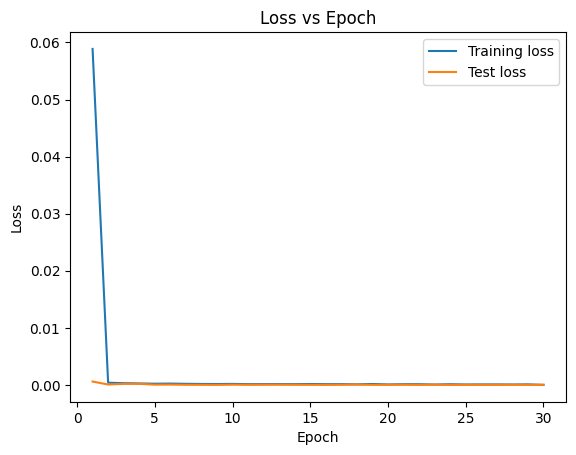

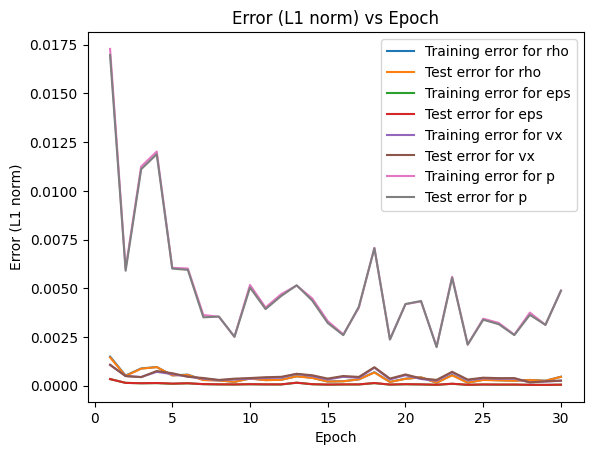

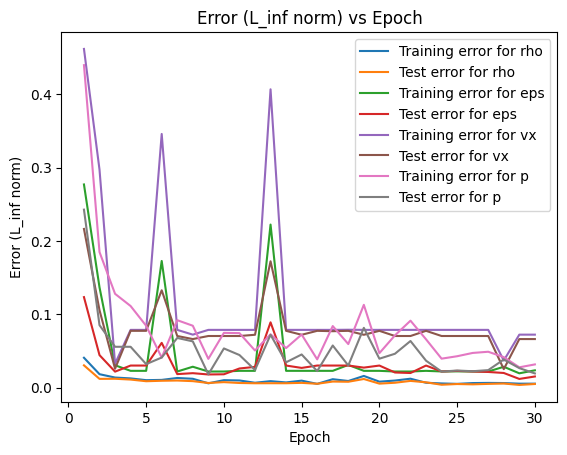

In [34]:

# Converting the lists of errors to numpy arrays for easier indexing
train_errors_L1 = np.array(train_errors_L1)
test_errors_L1 = np.array(test_errors_L1)
train_errors_Linf = np.array(train_errors_Linf)
test_errors_Linf = np.array(test_errors_Linf)

# Plotting the training and test losses against epochs
plt.figure()
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig('loss.png')

# Plotting the training and test errors in L1 norm against epochs for each primitive variable
plt.figure()
plt.plot(range(1, NUM_EPOCHS+1), train_errors_L1[:, 0], label='Training error for rho')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_L1[:, 0], label='Test error for rho')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_L1[:, 1], label='Training error for eps')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_L1[:, 1], label='Test error for eps')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_L1[:, 2], label='Training error for vx')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_L1[:, 2], label='Test error for vx')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_L1[:, 3], label='Training error for p')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_L1[:, 3], label='Test error for p')
plt.xlabel('Epoch')
plt.ylabel('Error (L1 norm)')
plt.title('Error (L1 norm) vs Epoch')
plt.legend()
plt.savefig('error_L1.png')

# Plotting the training and test errors in L_inf norm against epochs for each primitive variable
plt.figure()
plt.plot(range(1, NUM_EPOCHS+1), train_errors_Linf[:, 0], label='Training error for rho')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_Linf[:, 0], label='Test error for rho')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_Linf[:, 1], label='Training error for eps')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_Linf[:, 1], label='Test error for eps')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_Linf[:, 2], label='Training error for vx')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_Linf[:, 2], label='Test error for vx')
plt.plot(range(1, NUM_EPOCHS+1), train_errors_Linf[:, 3], label='Training error for p')
plt.plot(range(1, NUM_EPOCHS+1), test_errors_Linf[:, 3], label='Test error for p')
plt.xlabel('Epoch')
plt.ylabel('Error (L_inf norm)')
plt.title('Error (L_inf norm) vs Epoch')
plt.legend()
plt.savefig('error_Linf.png')

# Saving the model parameters to a file
torch.save(model.state_dict(), 'model.pth')

# Printing a message to indicate the end of the code
print("The code has finished running.")
